# Injury Prediction Modeling 

## Objective
To train and evaluate machine learning models for predicting athlete injuries using wearable device data from 1000 synthetic triathletes in 2024.

---

## Data Split Summary
- **Train/Test Split:** 80/20
- **Split Strategy:** 
    1. athlete based (800/200 athletes) **Focus on this for now**
    2. time based (november + december for testing rest for training)
- **Target Variable:** `injury` (Binary: 0 = No Injury, 1 = Injury)
- **Class Distribution (Training Set):**
    - 0:    0.942872
    - 1:    0.057128

---

## Modeling Approach

### Models to Compare (based on related work)
1. **LASSO Logistic Regression**
2. **Random Forest**
3. **Bagged XGBoost**

### Metrics for Evaluation
- Accuracy
- Precision / Recall / F1-score
- ROC-AUC
- Confusion Matrix

---

In [32]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your preprocessed train/test data
X_train = pd.read_csv('../simulated_data/processed/athlete_based/X_train.csv')
X_test = pd.read_csv('../simulated_data/processed/athlete_based/X_test.csv')
y_train = pd.read_csv('../simulated_data/processed/athlete_based/y_train.csv').values.ravel()  # Convert to 1D array
y_test = pd.read_csv('../simulated_data/processed/athlete_based/y_test.csv').values.ravel()

# Check class distribution
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

Class distribution in training set:
0    0.885641
1    0.114359
Name: proportion, dtype: float64


In [33]:
# Function to evaluate and visualize model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Print classification report
    print(f"\n--- {model_name} Performance ---")
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve (AUC = {auc:.4f})')
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve (AP = {avg_precision:.4f})')
    
    plt.tight_layout()
    plt.show()
    
    return model, auc, avg_precision

---

## Overview of the Models

### 1. LASSO Regression  (L1-Regularized Logistic Regression for Classification)

- **Purpose:** Performs both variable selection and regularization to prevent overfitting.

- **Pros:** 
    - Great for high-dimensional data.
    - Shrinks irrelevant features to zero (helps interpretability).
- **Cons:** May underperform on non-linear data unless features are carefully engineered.


In [21]:
# 1. LASSO (L1-regularized Logistic Regression)
print("\n===== Training LASSO Model =====")
# Calculate class weights for imbalanced data
class_weights = {0: 1, 1: sum(y_train == 0) / sum(y_train == 1)}

lasso = LogisticRegression(
    penalty='l1', 
    solver='liblinear',
    max_iter=1000,  # Limit iterations
    tol=0.001,      # Increase tolerance for faster convergence
    class_weight=class_weights, 
    random_state=42
)
lasso.fit(X_train, y_train)
lasso_model, lasso_auc, lasso_ap = evaluate_model(lasso, X_train, X_test, y_train, y_test, "LASSO")


===== Training LASSO Model =====


KeyboardInterrupt: 

---

### 2. Random Forest

- **Purpose:** Ensemble method using many decision trees trained on bootstrapped samples.

- **Pros:**
    - Handles non-linearity well.
    - Robust to outliers and noise.
    - Feature importance is easy to interpret.
- **Cons:**
    - May overfit if not tuned well (though less than individual trees).
    - Less interpretable than linear models.


===== Training Random Forest Model =====

--- Random Forest Performance ---
AUC: 0.8531
Average Precision: 0.7002
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     49156
           1       0.68      0.66      0.67      5854

    accuracy                           0.93     55010
   macro avg       0.82      0.81      0.82     55010
weighted avg       0.93      0.93      0.93     55010



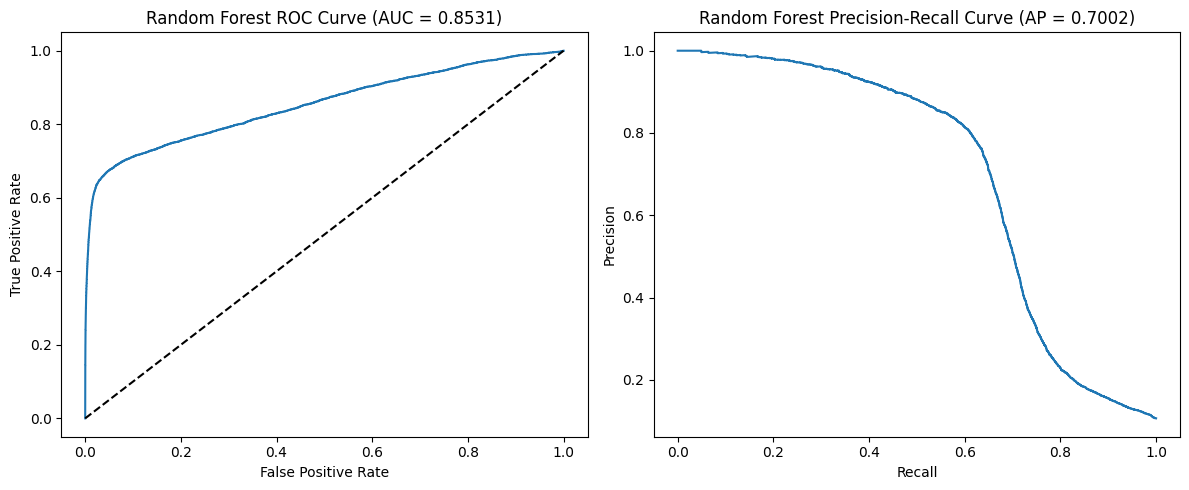


Random Forest feature importance (top 20):
                                  Feature  Importance
182                      stress_deviation    0.116277
222               consecutive_high_stress    0.094575
183                         stress_zscore    0.084856
223                     stress_risk_score    0.082772
221                       high_stress_day    0.056192
214                      stress_change_7d    0.048736
188                       stress_7d_trend    0.042233
180  resting_hr_daily_critical_window_sum    0.041045
12                                 stress    0.036344
210                     stress_volatility    0.032743
176    resting_hr_daily_consecutive_below    0.027962
213                      stress_change_3d    0.023004
211                stress_volatility_risk    0.019741
174               resting_hr_daily_zscore    0.017868
173            resting_hr_daily_deviation    0.017043
84                       resting_hr_ratio    0.016090
78                              hrv_ra

In [39]:
# 2. Random Forest with class weighting and adjustments
print("\n===== Training Random Forest Model =====")

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Adjusting class_weight to focus more on the injury class
rf = RandomForestClassifier(
    n_estimators=200,  # Increased number of trees for more stability
    max_depth=8,  # Increased depth to capture more complex patterns
    min_samples_leaf=7,  # To avoid overfitting, but can be tuned further
    class_weight={0: 1, 1: scale_pos_weight},  # Assign higher weight to injury class
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model
rf.fit(X_train, y_train)

# Evaluate the model
rf_model, rf_auc, rf_ap = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

# Feature importance
feature_names = X_train.columns
rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest feature importance (top 20):")
print(rf_importances.head(20))


In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

# Predict probabilities
y_proba = rf.predict_proba(X_test)[:, 1]

# Try different thresholds
threshold = 0.41  # Try 0.4, 0.3, 0.25, etc.
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluate recall and tradeoffs
recall = recall_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

print(f"\nAdjusted threshold evaluation (threshold={threshold}):")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))



Adjusted threshold evaluation (threshold=0.41):
Recall: 0.7259
Precision: 0.3206
F1 Score: 0.4448
Confusion Matrix:
[[3970  909]
 [ 162  429]]



---

### 3. Bagged XGBoost

- **Purpose:** Gradient boosting framework with regularization, but we’re bagging (aggregating multiple XGBoost models).

- **Pros:**
    - Extremely powerful, often achieves state-of-the-art results.
    - Handles missing values, non-linearity, and interactions well.
- **Cons:**
    - Computationally intensive.
    - Easy to overfit without proper tuning (especially with boosting and bagging together).


===== Training XGBoost Model =====

--- XGBoost Performance ---
AUC: 0.8524
Average Precision: 0.7093
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     49156
           1       0.60      0.69      0.64      5854

    accuracy                           0.92     55010
   macro avg       0.78      0.82      0.80     55010
weighted avg       0.92      0.92      0.92     55010



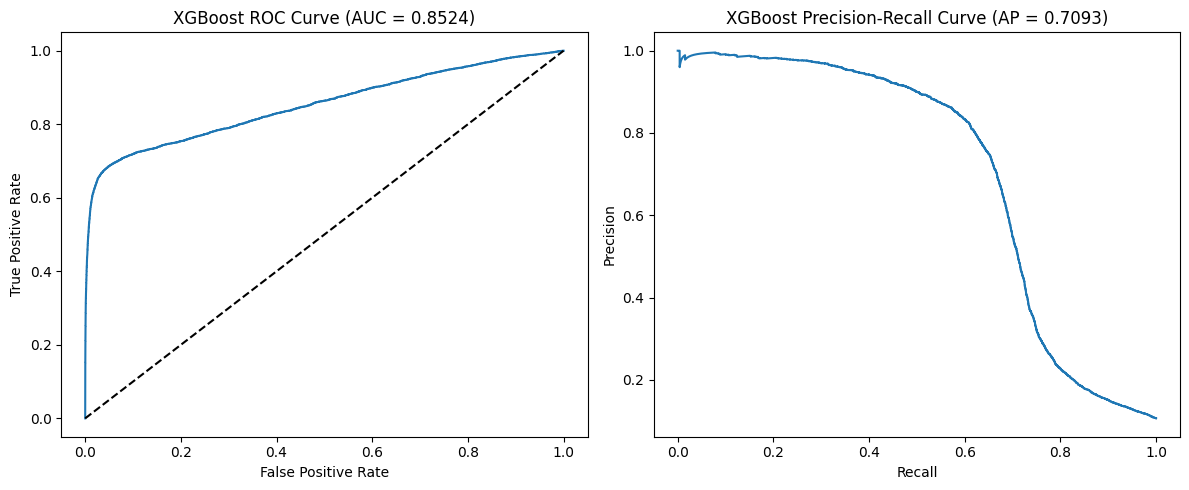


XGBoost feature importance (top 20):
                                  Feature  Importance
221                       high_stress_day    0.477781
223                     stress_risk_score    0.081563
182                      stress_deviation    0.080819
222               consecutive_high_stress    0.041208
176    resting_hr_daily_consecutive_below    0.029825
210                     stress_volatility    0.025681
173            resting_hr_daily_deviation    0.019959
214                      stress_change_7d    0.018749
180  resting_hr_daily_critical_window_sum    0.017981
188                       stress_7d_trend    0.015531
12                                 stress    0.010684
84                       resting_hr_ratio    0.010417
165                            hrv_zscore    0.007855
215                   stress_acceleration    0.007548
174               resting_hr_daily_zscore    0.006979
142              resting_hr_daily_z_score    0.006041
164                         hrv_deviation   

In [38]:
# 3. XGBoost with class weighting
print("\n===== Training XGBoost Model =====")
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

xgb = XGBClassifier(
    n_estimators=400,  # Increase to compensate for shallower trees
    max_depth=2,       # Try even lower depth
    learning_rate=0.03,  # Lower learning rate for better convergence
    subsample=0.8,     # More aggressive subsampling to reduce overfitting
    colsample_bytree=0.7,  # Sample fewer features per tree
    scale_pos_weight=scale_pos_weight,
    reg_alpha=1.0,     # L1 regularization to reduce complexity
    reg_lambda=2.0,    # L2 regularization
    random_state=42
)

xgb.fit(
    X_train, y_train,
)


xgb_model, xgb_auc, xgb_ap = evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")

# Feature importance
feature_names = X_train.columns
xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nXGBoost feature importance (top 20):")
print(xgb_importances.head(20))

In [12]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

# Predict probabilities
y_proba = xgb.predict_proba(X_test)[:, 1]

# Try different thresholds
threshold = 0.4  # Try 0.4, 0.3, 0.25, etc.
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluate recall and tradeoffs
recall = recall_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

print(f"\nAdjusted threshold evaluation (threshold={threshold}):")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))



Adjusted threshold evaluation (threshold=0.4):
Recall: 0.7191
Precision: 0.3758
F1 Score: 0.4936
Confusion Matrix:
[[4173  706]
 [ 166  425]]


In [ ]:
# Compare model performances
models = ['LASSO', 'Random Forest', 'XGBoost']
aucs = [lasso_auc, rf_auc, xgb_auc]
aps = [lasso_ap, rf_ap, xgb_ap]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, aucs, width, label='AUC')
plt.bar(x + width/2, aps, width, label='Average Precision')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

# Save best model (based on AUC)
best_model_idx = np.argmax(aucs)
best_model_name = models[best_model_idx]
best_models = [best_lasso, rf_model, xgb_model]
best_model = best_models[best_model_idx]

print(f"\nBest performing model: {best_model_name} (AUC: {aucs[best_model_idx]:.4f})")

[LightGBM] [Info] Number of positive: 25218, number of negative: 195299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39612
[LightGBM] [Info] Number of data points in the train set: 220517, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

--- LightGBM Performance ---
AUC: 0.8542
Average Precision: 0.7299
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     49156
           1       0.68      0.69      0.68      5854

    accuracy                           0.93     55010
   macro avg       0.82      0.82      0.82     55010
weighted avg       0.93      0.93      0.93     55010



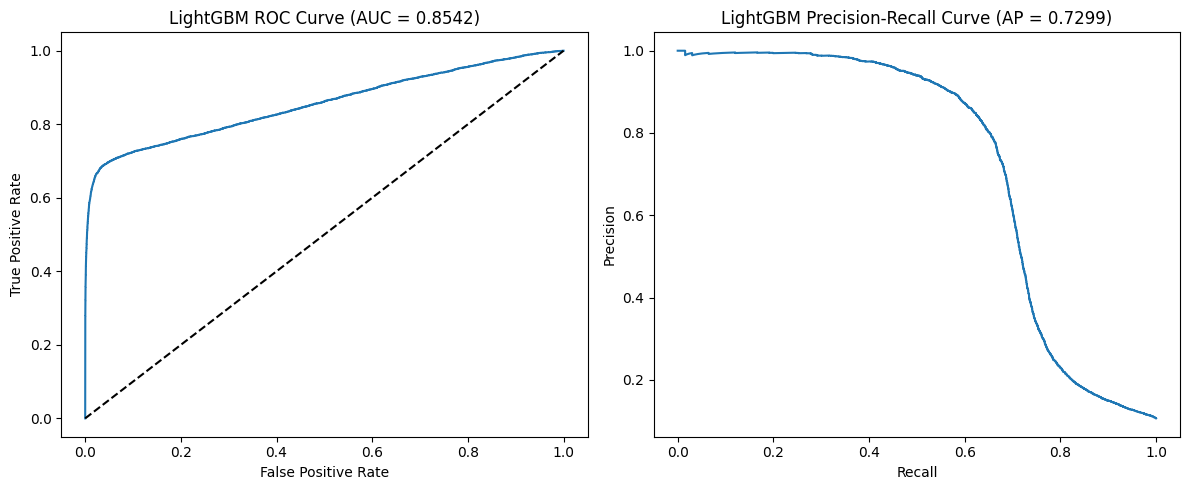


LightGBM feature importance (top 15):
                           Feature  Importance
172      resting_hr_daily_baseline         330
12                          stress         281
181                stress_baseline         256
182               stress_deviation         248
84                resting_hr_ratio         213
212               stress_change_1d         197
210              stress_volatility         194
104               chronic_load_42d         192
190  body_battery_morning_baseline         161
78                       hrv_ratio         159
139              sleep_hours_cv_7d         152
138                      hrv_cv_7d         152
13            body_battery_evening         136
99                      tss_7d_std         135
188                stress_7d_trend         132


In [36]:
# Try LightGBM which often handles imbalanced data well
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    n_estimators=300,
    learning_rate=0.05
)
lgb_model.fit(X_train, y_train)
lgb_eval, lgb_auc, lgb_ap = evaluate_model(lgb_model, X_train, X_test, y_train, y_test, "LightGBM")

# Feature importance
feature_names = X_train.columns
lgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nLightGBM feature importance (top 15):")
print(lgb_importances.head(15))
